In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from datetime import datetime
from dateutil.relativedelta import relativedelta



In [2]:
import calendar

def midpoint_of_month(year, month):
    # Get the last day of the month
    last_day = calendar.monthrange(year, month)[1]
    # Calculate the midpoint day (middle of the month)
    midpoint_day = (last_day + 1) // 2
    # Return the midpoint date
    return datetime(year, month, midpoint_day)

def days_in_month(year, month):
    return calendar.monthrange(year, month)[1]


### Read the dataframe

In [3]:
#master_df.to_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv")
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)

### Now compute the CRE and CRF

In [4]:
cre_sw = (master_df.qcrad_swd - master_df.rrtmg_swd_clear).where(master_df.shadow<.3).fillna(0)
cre_lw = (master_df.qcrad_lwd - master_df.rrtmg_lwd_clear)
crf_sw = (cre_sw * (1-master_df.albedo))
crf_lw = cre_lw + (master_df.ml_lwu_clear - master_df.qcrad_lwu)
crf_net = crf_sw + crf_lw
cre_net = cre_sw + cre_lw


In [5]:
master_df

,cza,az,hangle,shadow,rrtmg_lwd_clear,rrtmg_swd_clear,rrtmg_swd_toa,qcrad_swd,qcrad_lwd,qcrad_lwu,ml_lwu_clear,albedo
time,,,,,,,,,,,,
2021-09-01 00:00:00,0.316518,4.638154,0.400730,1.0,293.034095,5.807844e+01,1.311600e+02,143.172791,328.463409,419.6888,408.302003,0.161625
2021-09-01 01:00:00,0.119591,4.802866,0.396977,1.0,291.085754,4.024271e-08,1.340151e-07,37.100533,340.761292,395.3617,384.450449,0.161625
2021-09-01 02:00:00,-0.063502,4.967340,0.377023,1.0,287.139933,4.044333e-08,1.340151e-07,-0.445339,354.581299,385.3151,371.170141,0.161625
2021-09-01 03:00:00,-0.271003,5.144844,0.320632,1.0,288.333086,4.036838e-08,1.340151e-07,-0.961659,348.295685,383.7052,367.851957,0.161625
2021-09-01 04:00:00,-0.434753,5.349328,0.232691,1.0,287.181333,4.042483e-08,1.340151e-07,-0.823483,353.995209,376.2189,366.257715,0.161625
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 20:00:00,0.944649,3.817532,0.157356,0.0,270.050352,1.031639e+03,1.243984e+03,855.102783,309.679993,443.0575,433.889754,0.161417
2023-06-14 21:00:00,0.879684,4.270627,0.269956,0.0,271.923479,9.464312e+02,1.152980e+03,1140.335938,309.743988,464.5136,450.934943,0.161417
2023-06-14 22:00:00,0.771766,4.529085,0.398510,0.0,272.600141,8.103561e+02,1.005858e+03,681.669128,298.776215,426.9277,428.795132,0.161417


In [6]:
rnet = master_df.qcrad_swd + master_df.qcrad_lwd  - master_df.qcrad_lwu - master_df.albedo*master_df.qcrad_swd

In [7]:
master_df['rnet'] = rnet

In [8]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 6000 ] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1
master_df['cloud_present'] = cloud_present_kolias.resample("1h").mean().reindex(master_df.index)

In [9]:
master_df['cloud_present'] = cloud_present_kolias.resample("1h").mean().reindex(master_df.index)

Text(0.5, 0, 'Hour (UTC)')

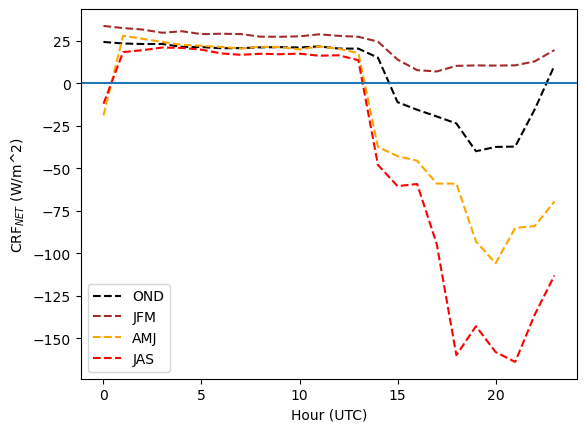

In [10]:
cold_crf = crf_net[crf_net.index.month.isin([10,11,12])]
cold_crf.groupby(cold_crf.index.hour).mean().plot(color='black', linestyle='--', label='OND')

cold_crf = crf_net[crf_net.index.month.isin([1,2,3])]
cold_crf.groupby(cold_crf.index.hour).mean().plot(color='brown', linestyle='--', label='JFM')


warm_crf = crf_net[crf_net.index.month.isin([4,5,6])]
warm_crf.groupby(warm_crf.index.hour).mean().plot(color='orange', linestyle='--', label='AMJ')

cold_crf = crf_net[crf_net.index.month.isin([7,8,9])]
cold_crf.groupby(cold_crf.index.hour).mean().plot(color='red',   linestyle='--', label='JAS')

plt.legend()
plt.axhline(0)
plt.ylabel("CRF$_{NET}$ (W/m^2)")
plt.xlabel("Hour (UTC)")

In [11]:
def resamp_midpoint(df, freq):
    dlist = []
    mnlist = []
    for gp in df.resample(freq):
        midpoint = pd.Interval(gp[-1].index[0], gp[-1].index[-1]).mid
        dlist.append(midpoint)
        mnlist.append(gp[-1].mean())
    return pd.Series(mnlist, index=dlist)

crf_net_1m = resamp_midpoint(crf_net.bfill(), "1m")
crf_net_1d = resamp_midpoint(crf_net.bfill(), "1d")



In [12]:
def resamp_midpoint_counter(df, freq, fx=np.mean):
    dlist = []
    mnlist = []
    for gp in df.resample(freq):
        midpoint = pd.Interval(gp[-1].index[0], gp[-1].index[-1]).mid
        dlist.append(midpoint)
        mnlist.append(fx(gp[-1]))
    return pd.Series(mnlist, index=dlist)

In [13]:
def add_plot(var, ax, color='orange', label='None'):
    #crf_net.resample("1d").mean().plot(ax=ax, color='orange', label='CRF$_{NET} Monthly$', marker='o', markersize=3, linewidth=1, zorder=1)
    crevar    = resamp_midpoint(var,   "1m")
    mwidth = np.array([days_in_month(y, m) for y,m in zip(crevar.index.year, crevar.index.month)] )
    mwidth[-1] = 15
    ax.bar(crevar.index,  width=mwidth,  height=crevar, color=color, label=label)#, align='edge')




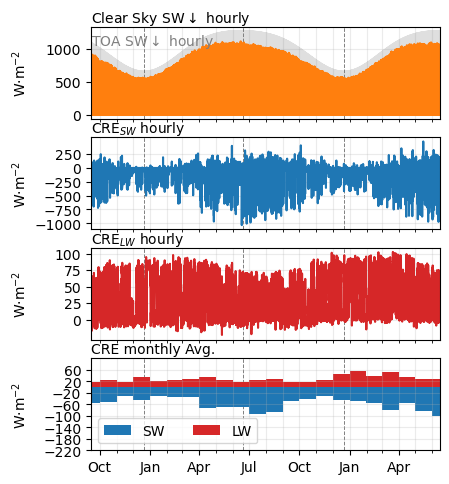

In [14]:
fig,ax= plt.subplots(4,  figsize=(4.5,5.5))


ax[0].plot(master_df.rrtmg_swd_toa.index, master_df.rrtmg_swd_toa, label="TOA SW", color='gray', alpha=.25)
ax[0].plot(master_df.rrtmg_swd_clear.index, master_df.rrtmg_swd_clear, label="SWD Clear", color='tab:orange')

ax[1].plot(cre_sw.index, cre_sw, color='tab:blue')
ax[2].plot(cre_lw.index, cre_lw, color='tab:red')

add_plot(cre_sw, ax[3], color='tab:blue', label='SW')
add_plot(cre_lw, ax[3], color='tab:red',  label='LW')


major_locator = mdates.MonthLocator(bymonth=[10, 1, 4, 7])  # Major ticks every 1 day
minor_locator = mdates.MonthLocator(bymonth=range(13))            # Minor ticks every 6 hours
major_formatter = mdates.DateFormatter('%b')                      # Format major ticks as 'YYYY-MM-DD'
minor_formatter = mdates.DateFormatter('')                        # Format minor ticks as 'HH:MM'


for axx in ax.flatten():
    axx.xaxis.set_major_locator(major_locator)
    axx.xaxis.set_minor_locator(minor_locator)
    axx.xaxis.set_major_formatter(major_formatter)
    axx.xaxis.set_minor_formatter(minor_formatter)
    for tick in axx.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
        tick.label1.set_rotation('horizontal')
        
    axx.grid(alpha=.25, which='both')

    # set the limits
    axx.set_xlim(pd.to_datetime("2021-09-15"), pd.to_datetime("2023-06-15"))


for x in [0,1,2]:
    ax[x].set_xticks( [])

ax[0].text(0, 1.05, "Clear Sky SW$\downarrow$ hourly", transform=ax[0].transAxes)# fontweight='bold')
ax[0].text(0, .80,  r"TOA SW$\downarrow$ hourly",      transform=ax[0].transAxes, color='gray')
ax[1].text(0, 1.05, "CRE$_{SW}$ hourly",                   transform=ax[1].transAxes)
ax[2].text(0, 1.05, "CRE$_{LW}$ hourly",                   transform=ax[2].transAxes)# fontweight='bold')
ax[3].text(0, 1.05, "CRE monthly Avg.",                transform=ax[3].transAxes)# fontweight='bold')


# adjust some yticks
ax[1].set_yticks(np.arange(-1000, 500, 250))
ax[2].set_yticks(np.arange(0, 125, 25))
ax[3].set_yticks(np.arange(-220, 80, 40))
ax[3].set_ylim(-220, 100)

for i in [0,1, 2, 3]:
    axx = ax[i]
    axx.axvline(x=pd.to_datetime("2022-06-20 00:00:00"), color='k', linewidth=.70, linestyle='--', zorder=0, alpha=.5) 
    axx.axvline(x=pd.to_datetime("2021-12-21 00:00:00"), color='k', linewidth=.70, linestyle='--', zorder=0, alpha=.5) 
    axx.axvline(x=pd.to_datetime("2022-12-21 00:00:00"), color='k', linewidth=.70, linestyle='--', zorder=0, alpha=.5) 
    axx.set_ylabel("W$\cdot$m$^{-2}$")

ax[3].legend(ncol=2, loc='lower left')
fig.align_ylabels(ax)


plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_cre_hourly_timeseries", dpi=300,  bbox_inches="tight")


<AxesSubplot: xlabel='time'>

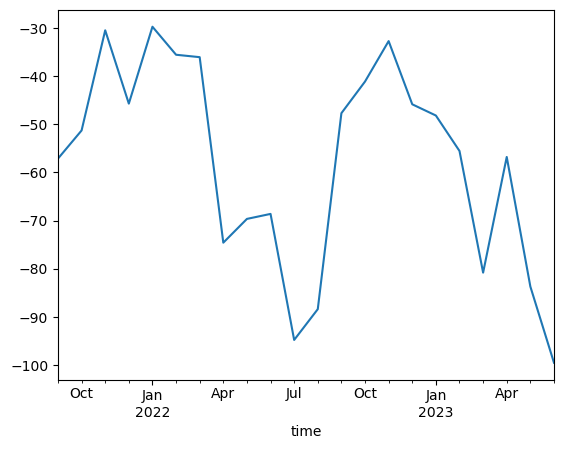

In [15]:
cre_sw.resample("1m").mean().plot()

In [16]:
master_df['crf_net'] = crf_net

In [17]:
# fig,ax = plt.subplots(1, figsize=(4.5, 3.5))

# dr = pd.date_range("2000-01-01", "2000-02-20",freq='1d')

# ax.bar(dr, range(len(dr)), width=.5, facecolor='none', edgecolor='black', linewidth=1)
# ax.bar(dr, range(len(dr)), width= .25, align='edge', color='green', alpha=.5)
# ax.bar(dr, range(len(dr)), width=-.25, align='edge', color='orange', alpha=.5)


In [18]:
def add_plot(ax):
    # creatre the data
    daytime_crf   = master_df['crf_net'].where(master_df.cza>0)#.fillna(0)
    nighttime_crf = master_df['crf_net'].where(master_df.cza<0)#.fillna(0)


    #crf_net.resample("1d").mean().plot(ax=ax, color='orange', label='CRF$_{NET} Monthly$', marker='o', markersize=3, linewidth=1, zorder=1)
    dcrf    = resamp_midpoint(daytime_crf,   "1m")
    ncrf    = resamp_midpoint(nighttime_crf, "1m")
    all_crf = resamp_midpoint(master_df['crf_net'], "1m")
    mwidth = np.array([days_in_month(y, m) for y,m in zip(all_crf.index.year, all_crf.index.month)] )
    mwidth[-1] = 15

    bottom_positions = dcrf.where(dcrf>0, 0)

    
    ax.bar(dcrf.index, width=mwidth/2,   height=dcrf,      color='orange', align='edge', label='day')
    ax.bar(ncrf.index, width=-mwidth/2,  height=ncrf,      color='purple', align='edge', label='night')
    ax.bar(all_crf.index, width=mwidth,     height=all_crf, facecolor='none', edgecolor='firebrick', linewidth=1.5, label='24h')

    # ax.bar(all_crf.index,    width=mwidth,   height=dcrf,      color='orange', label='day')
    # ax.bar(all_crf.index,    width=mwidth,   height=ncrf-bottom_positions, bottom=bottom_positions, color='purple', label='night')
    # ax.bar(all_crf.index,    width=mwidth,   height=all_crf,   facecolor='none', edgecolor='red', linewidth=1.5, label='24h')
    ax.legend(ncol=3)

In [19]:
master_df['crf_net'] 

time
2021-09-01 00:00:00     24.042517
2021-09-01 01:00:00     38.764287
2021-09-01 02:00:00     53.296407
2021-09-01 03:00:00     44.109355
2021-09-01 04:00:00     56.852690
                          ...    
2023-06-14 20:00:00   -117.578270
2023-06-14 21:00:00    186.847068
2023-06-14 22:00:00    -79.871263
2023-06-14 23:00:00     58.946014
2023-06-15 00:00:00   -228.985631
Name: crf_net, Length: 15649, dtype: float64

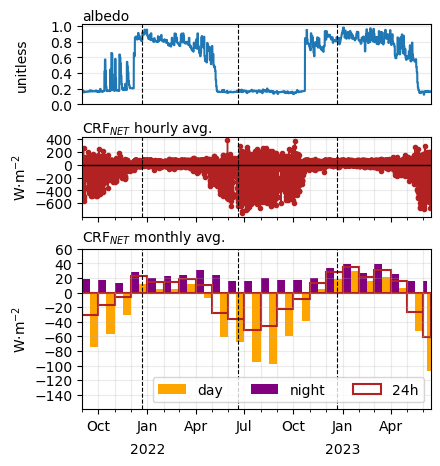

In [20]:
### make a big figure showing the whole thing 
red, purple, green, blue= '#D57E6C', '#6CC3D5', '#8FD56C', '#B36CD5'

fig,ax=plt.subplots(3, 1, figsize=(4.5, 5.0), gridspec_kw={'height_ratios': [1,1,2]})

#crf_lw.plot(ax=ax[0],    label="CRE$_SW$",color='dodgerblue')

# month crf
ax[1].plot(crf_net.index, crf_net.values, color='firebrick', label='CRF$_{NET} Monthly$', marker='o', markersize=3, linewidth=1)
#

add_plot(ax[2])
master_df.albedo.plot(ax=ax[0], label="albedo")

# keepxtcks =   ax[0].get_xticklabels()
# keepxtcklab = ax[0].get_xticks()

#crf_net.shift(-15 * 24).resample("1m").mean().reindex(master_df.index).interpolate().bfill().plot(ax=ax[1],  label='CRF$_{NET} Monthly$',  linewidth=1.5)

ax[1].axhline(0, color='black', linewidth=1.0)


##################################
### do the label stylying 
##################################
ax[0].text(0, 1.05, "albedo",                transform=ax[0].transAxes)# fontweight='bold')
ax[1].text(0, 1.05, r"CRF$_{NET}$ hourly avg.",   transform=ax[1].transAxes)# fontweight='bold')
ax[2].text(0, 1.05,  r"CRF$_{NET}$ monthly avg.",   transform=ax[2].transAxes)# fontweight='bold')



##### loop through the axes 
for axx in ax.flatten():
    axx.axvline(x=pd.to_datetime("2022-06-20 00:00:00"), color='k', linewidth=.8, linestyle='--') 
    axx.axvline(x=pd.to_datetime("2021-12-21 00:00:00"), color='k', linewidth=.8, linestyle='--') 
    axx.axvline(x=pd.to_datetime("2022-12-21 00:00:00"), color='k', linewidth=.8, linestyle='--') 
    axx.set_xlim(pd.to_datetime("2021-09-01"), pd.to_datetime("2023-06-15"))

ax[0].set_ylabel("unitless")


major_locator = mdates.MonthLocator(bymonth=[10, 1, 4, 7])  # Major ticks every 1 day
minor_locator = mdates.MonthLocator(bymonth=range(13))            # Minor ticks every 6 hours
major_formatter = mdates.DateFormatter('%b')                      # Format major ticks as 'YYYY-MM-DD'
minor_formatter = mdates.DateFormatter('')                        # Format minor ticks as 'HH:MM'


for axx in ax.flatten():
    axx.xaxis.set_major_locator(major_locator)
    axx.xaxis.set_minor_locator(minor_locator)
    axx.xaxis.set_major_formatter(major_formatter)
    axx.xaxis.set_minor_formatter(minor_formatter)
    for tick in axx.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
        tick.label1.set_rotation('horizontal')
    axx.grid(alpha=.25, which='both')



ax[-1].text(pd.to_datetime("2022-01-01 00:00:00"), -220, "2022", color='black', horizontalalignment='center')
ax[-1].text(pd.to_datetime("2023-01-01 00:00:00"), -220, "2023", color='black', horizontalalignment='center')
ax[-1].set_xlabel("")
ax[-1].set_ylim(-150,80)

fig.align_ylabels(ax[:])
for axx in ax.flatten()[:-1]:
    axx.set_xticklabels([])

ax[1].set_ylabel("W$\cdot$m$^{-2}$")
ax[2].set_ylabel("W$\cdot$m$^{-2}$")


# style the y axes ticks
ax[0].set_yticks(np.arange(0.0, 1.2, 0.2))
ax[1].set_yticks(np.arange(-600, 600, 200))
ax[2].set_yticks(np.arange(-140, 80, 20))
ax[2].set_ylim(-160, 60)

ax[0].set_xlabel("")
plt.subplots_adjust(hspace=.3)
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_crf_hourly_timeseries", dpi=300,  bbox_inches="tight")


In [44]:
crf_net['2022-01-01':'2023-01-01'].mean()

-7.923568986052922

### unrealized cooling due to albedo

In [21]:
unrel_cool = resamp_midpoint(cre_net - crf_net, "1m")


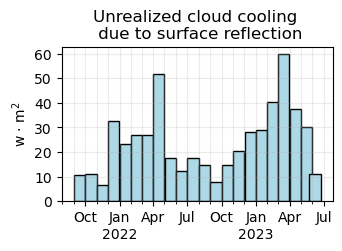

In [22]:
fig, ax = plt.subplots(1, figsize=(3.5,2))#, gridspec_kw={'width_ratios': [2,1]})


#ax2 = axx[1]
#ax2.scatter(resamp_midpoint(master_df.albedo, "1d"), resamp_midpoint(cre_net - crf_net, "1d"), s=1)

ax.bar(unrel_cool.index, -1*unrel_cool, width=30, color='lightblue', edgecolor='black')

major_locator = mdates.MonthLocator(bymonth=[10, 1, 4, 7])  # Major ticks every 1 day
minor_locator = mdates.MonthLocator(bymonth=range(13))            # Minor ticks every 6 hours
major_formatter = mdates.DateFormatter('%b')                      # Format major ticks as 'YYYY-MM-DD'
minor_formatter = mdates.DateFormatter('')                        # Format minor ticks as 'HH:MM'


ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_minor_locator(minor_locator)
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_minor_formatter(minor_formatter)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
    tick.label1.set_rotation('horizontal')
ax.grid(alpha=.25, which='both')



ax.text(pd.to_datetime("2022-01-01 00:00:00"), -15, "2022", color='black', horizontalalignment='center')
ax.text(pd.to_datetime("2023-01-01 00:00:00"), -15, "2023", color='black', horizontalalignment='center')
ax.set_xlabel("")
#ax.set_ylim(-150,80)
ax.set_title("Unrealized cloud cooling \n due to surface reflection")
ax.set_ylabel(r"w $\cdot$ m$^2$")
ax.set_yticks(np.arange(0, 70, 10))
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_unrealized_cooling", dpi=300,  bbox_inches="tight")


Text(0.5, 0, 'DayofYear')

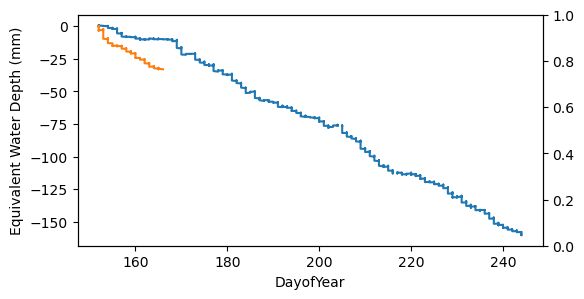

In [23]:
lm    = 334E3     # J/kg 
vph2o =  2.25e6    # J/kg

# j/(s*m2) * total time (s) / lm (j/kg) == kg/m2

fig,ax= plt.subplots(1, figsize=(6,3), sharey=True)
ax2 = ax.twinx()

sd1="2022-06-01"
ed1="2022-09-01"

sd2="2023-06-01"
ed2="2023-09-01"

y1 = ((crf_net[sd1:ed1] * 60 * 60).cumsum()/vph2o)
y2 = ((crf_net[sd2:ed2] * 60 * 60).cumsum()/vph2o)

ax.plot(y1.index.dayofyear, y1)
ax.plot(y2.index.dayofyear, y2)

#albedo_daily[sd1:ed1].plot(ax=ax2, color='red')
ax.set_ylabel("Equivalent Water Depth (mm)")
ax.set_xlabel("DayofYear")

### what is the equivalent amount of ET 

In [24]:
crf_net['2022-06-01':'2022-09-01'].sum() * 3600 / vph2o  

-159.9003271124133

In [25]:
crf_net['2022-06-01':'2022-09-01'].mean()

-44.87548470824351

### make some plots to put in the supp. material

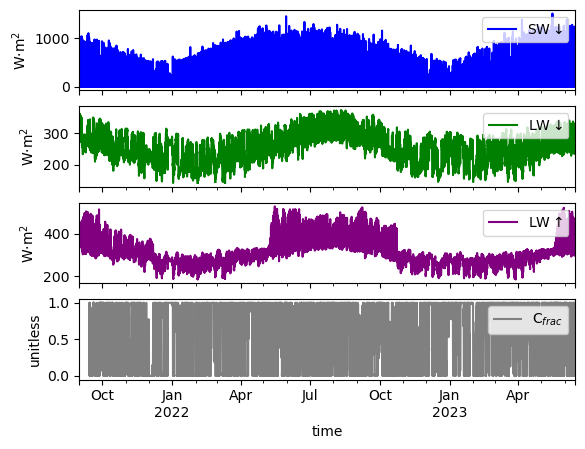

In [26]:
fig, ax = plt.subplots(4,1, sharex=True)
master_df.qcrad_swd.plot(ax=ax[0],     color='blue',     label=r'SW$\downarrow$')
master_df.qcrad_lwd.plot(ax=ax[1],     color='green',    label=r'LW$\downarrow$')
master_df.qcrad_lwu.plot(ax=ax[2],     color='purple',   label=r'LW$\uparrow$')
master_df.cloud_present.plot(ax=ax[3], color='gray',     label=r'C$_{frac}$')

for axx in ax.flatten(): #[0:-1]:
    axx.set_ylabel("W$\cdot$m$^2$")
    axx.legend(loc='upper right')
# master_df.ml_lwu_clear.plot(ax=ax[3])

ax[-1].set_ylabel("unitless")
ax[-1].set_yticks([0,.5,1])

plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Supp_FigureX_obs_radiation_timeseries", dpi=300,  bbox_inches="tight")



In [27]:
master_df.columns

Index(['cza', 'az', 'hangle', 'shadow', 'rrtmg_lwd_clear', 'rrtmg_swd_clear',
       'rrtmg_swd_toa', 'qcrad_swd', 'qcrad_lwd', 'qcrad_lwu', 'ml_lwu_clear',
       'albedo', 'rnet', 'cloud_present', 'crf_net'],
      dtype='object')

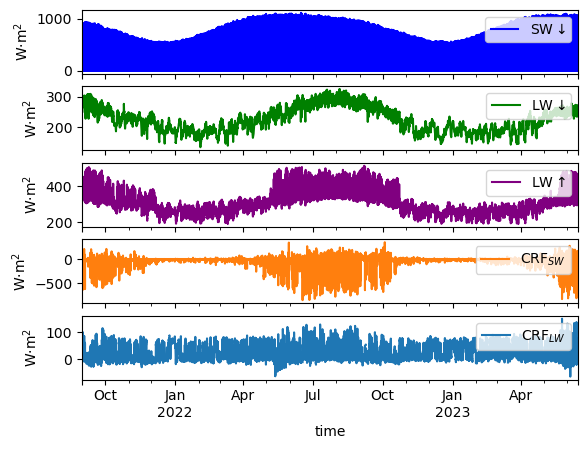

In [28]:
fig, ax = plt.subplots(5,1, sharex=True)
master_df.rrtmg_swd_clear.plot(ax=ax[0],     color='blue',     label=r'SW$\downarrow$')
master_df.rrtmg_lwd_clear.plot(ax=ax[1],     color='green',    label=r'LW$\downarrow$')
master_df.ml_lwu_clear.plot(ax=ax[2],        color='purple',   label=r'LW$\uparrow$')
crf_sw.plot(ax=ax[3], color='tab:orange', label='CRF$_{SW}$')
crf_lw.plot(ax=ax[4], color='tab:blue', label='CRF$_{LW}$')

for axx in ax.flatten(): #[0:-1]:
    axx.set_ylabel("W$\cdot$m$^2$")
    axx.legend(loc='upper right')
# master_df.ml_lwu_clear.plot(ax=ax[3])


plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Supp_FigureX_model_radiation_timeseries", dpi=300,  bbox_inches="tight")



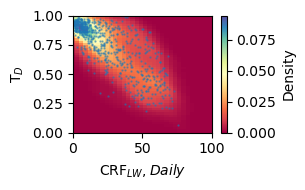

In [29]:
import scipy.stats as stats
fig, ax = plt.subplots(1, figsize=(3,2) )#2,3, figsize=(5,2.5), gridspec_kw={"height_ratios":[1,.05]})

###
tauhr = master_df[['rrtmg_swd_clear', 'qcrad_swd', 'cloud_present']].dropna()
tau1d = tauhr.resample("1d").mean()
trans1d = tau1d.qcrad_swd / tau1d.rrtmg_swd_clear
cfrac1d = tauhr.cloud_present.resample("1d").mean()

#### do lw and transmissibvity 
xmin=0.
xmax=150.
ymin=0.
ymax=1



xdat = crf_lw.resample("1d").mean().loc[trans1d.index] #tauhr['cre_lw']
ydat = trans1d # np.exp(-1*tauhr['tauhr'])


X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([xdat, ydat])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)


cfset = ax.pcolormesh(X, Y, Z, cmap='Spectral')
cbar = fig.colorbar(cfset, ax=ax, orientation='vertical')
cbar.set_label('Density')


ax.scatter(xdat, ydat,  s=.5, alpha=.5)
ax.set_xlim(0,100)#[xmin, xmax])
ax.set_ylim(0,1.0) #[ymin, ymax])
#ax.contour(X, Y, Z, colors='k', linewidths=.5)


ax.set_ylabel(r"T$_D$")
ax.set_xlabel("CRF$_{LW}, Daily$")


ax.set_yticks([0, .25, .5, .75, 1])

plt.tight_layout()

plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Supp_FigureX_crf_lw_transmissivity", dpi=300,  bbox_inches="tight")

In [30]:
#plt.scatter(master_df.cloud_present, crf_lw, s=.1)

#def group_by_cfrac():
counts, bins = np.histogram(master_df.cloud_present, bins=[0, .25, .5, .75, 1.0])


In [31]:
master_df['crf_net'] = crf_net
master_df['cre_sw'] = cre_sw
master_df['cre_lw'] = cre_lw
master_df['crf_sw'] = crf_sw
master_df['crf_lw'] = crf_lw


In [32]:
mdfnona = master_df.dropna()

In [33]:
def return_bin_mean(var1, var2, bins):
    thesum, b  = np.histogram(var1, bins=bins, weights=var2)
    count, b   = np.histogram(var1, bins=bins)
    return thesum/count, bins 


In [34]:
avg_sw, bins = return_bin_mean(mdfnona.cloud_present, mdfnona.crf_sw, np.linspace(0,1,11))
avg_lw, bins = return_bin_mean(mdfnona.cloud_present, mdfnona.crf_lw, np.linspace(0,1,11))
avg_net, bins = return_bin_mean(mdfnona.cloud_present, mdfnona.crf_net, np.linspace(0,1,11))

In [35]:
bins = np.linspace(0,1,11)

In [36]:
bin_centers = (bins[1:] + bins[:-1])/2

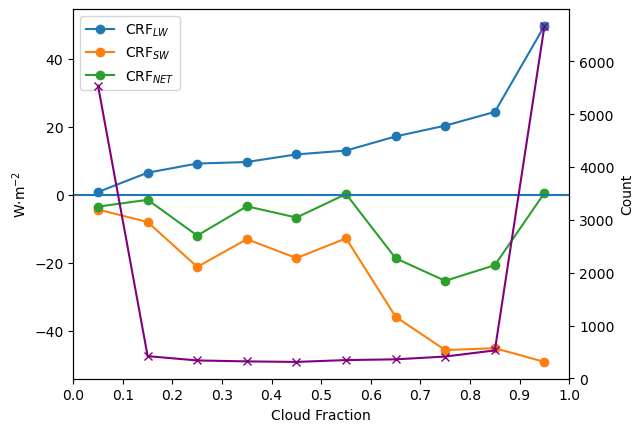

In [37]:
#master_df[master_df.cloud_present > .5].cre_lw.mean()
fig, ax = plt.subplots(1)
ax.plot(bin_centers, avg_lw, marker='o', label=r'CRF$_{LW}$')
ax.plot(bin_centers, avg_sw, marker='o', label=r'CRF$_{SW}$')
ax.plot(bin_centers, avg_net, marker='o', label=r'CRF$_{NET}$')
ax.axhline(0)
ax.legend()
ax.set_xlabel("Cloud Fraction")
ax.set_ylabel("W$\cdot$m$^{-2}$")

ax2 = ax.twinx()
#plt.scatter(mdfnona.cloud_present, mdfnona.crf_lw, s=.1, alpha=.5)
#plt.scatter(mdfnona.cloud_present, mdfnona.crf_sw, s=.1, alpha=.5)
#plt.scatter(mdfnona.cloud_present, mdfnona.crf_net, s=.1)
#plt.ylim(-200,200)


counts, bins  = np.histogram(mdfnona.cloud_present, bins=np.linspace(0,1,11))
ax2.plot(bin_centers, counts, color='purple', marker='x')
ax2.set_ylabel("Count")

ax.set_xticks(np.linspace(0,1,11))
ax2.set_xticks(np.linspace(0,1,11))


plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Supp_FigureX_crf_cfrac")

In [38]:
cre_sw = (master_df.qcrad_swd - master_df.rrtmg_swd_clear).where(master_df.shadow<.3).fillna(0)
cre_lw = (master_df.qcrad_lwd - master_df.rrtmg_lwd_clear)
crf_sw = (cre_sw * (1-master_df.albedo))
crf_lw = cre_lw + (master_df.ml_lwu_clear - master_df.qcrad_lwu)
crf_net = crf_sw + crf_lw
cre_net = cre_sw + cre_lw


In [39]:
#plt.plot((master_df.qcrad_lwd - master_df.rrtmg_lwd_clear).resample("1m").mean())
#plt.plot((master_df.qcrad_lwu - master_df.rrtmg_lwd_clear).resample("1m").mean())


lw_net_clear = (master_df.rrtmg_lwd_clear - master_df.ml_lwu_clear).resample("1m").mean()
lw_net_cloud = (master_df.qcrad_lwd - master_df.qcrad_lwu).resample("1m").mean()

<AxesSubplot: xlabel='time'>

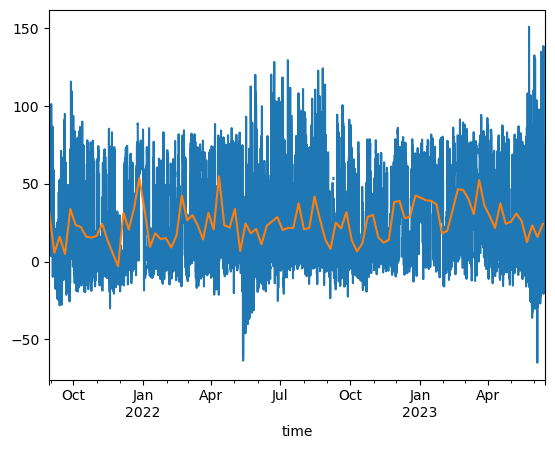

In [40]:
#(lw_net_cloud - lw_net_clear).plot()
crf_lw.plot()
crf_lw.resample("1w").mean().plot()

In [41]:
# plt.scatter(master_df.cloud_present.resample("1d").mean(), 
#             crf_net.resample("1d").mean(), 
#             c = master_df.albedo.resample("1d").mean(), s=10)